In [1]:
import warnings 
warnings.filterwarnings("ignore")

1. Объясните, почему коэффициенты всех построенных моделей сильно отличаются между собой.



В рамках первых двух моделей мы реализовали линейную регрессию, применяя как обычный, так и стохастический градиентные спуски. При фиксированной скорости обучения мы варьировали количество итераций (400 и 50) для обычного и стохастического градиентных спусков соответственно. В стохастическом градиентном спуске мы также установили размер подвыборки (batch_size) равным 8, что означает, что обучающая выборка была разделена на подгруппы по 8 элементов. Основное отличие между GD и SGD заключается в том, что при GD мы подаем весь набор данных для обучения, в то время как при SGD мы передаем его по частям в случайном порядке. Это увеличивает скорость сходимости и, следовательно, уменьшает количество необходимых итераций для достижения сходимости.

В последующих моделях мы реализовали SGD с различными параметрами в трех моделях, а также одну модель GD, меняя значения параметров. Во всех случаях SGD продемонстрировал лучшие результаты по функции потерь. Однако наблюдается интересная динамика: при постоянных значениях функции потерь точность модели пропорциональна увеличению размера подвыборки (batch_size) и обратно пропорциональна количеству итераций (max_iter).

2. Сравните скорость и качество обучения моделей регрессии с помощью обычного и стохастического градиентного спуска на наборе данных housing.csv.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split


df = pd.read_csv('housing.csv')

X = df.drop('Y', axis=1)
y = df['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Columns: 104 entries, Column1 to Column104
dtypes: float64(104)
memory usage: 411.3 KB


In [3]:
class LinearRegressionGD:
    def __init__(self, lr=0.01, max_iter=1000, tol=1e-3, intercept = True):
        # скорость обучения градиентного спуска
        self.learning_rate = lr 
        # максимальное число итераций
        self.max_iteration = max_iter 
        # критерий сходимости  
        self.tolerance_convergence  = tol
        # наличие свободного члена
        self.intercept = intercept
        # инициальзация весов: None
        self.theta = None
        self.n = None
        self.d = None
         
    def fit(self, X, y):
        self.X = X.to_numpy().copy()
        if self.intercept:
            self.X = np.hstack((np.ones((self.X.shape[0], 1)), self.X))   
        # размерность вектора X 
        self.n, self.d = self.X.shape
        # инициализация случайных весов
        self.theta = np.random.randn(self.d)
        steps, errors = [], []
        step = 0
        for _ in range(self.max_iteration):
            grad = self.gradient(self.X, y)
            self.theta -= self.learning_rate * grad
            new_error = ((y - self.predict(X)).T @ (y - self.predict(X))) / self.n
            step += 1
            steps.append(step)
            errors.append(new_error)
            # проверка сходимости
            if np.linalg.norm(grad) < self.tolerance_convergence:
                break
        return steps, errors
    
    def gradient(self, X, y):
        return X.T @ (X @ self.theta - y) / len(y)
             
    def predict(self, X):
        if self.intercept:
            X_ = np.hstack((np.ones((X.shape[0],1)), X))
        else:
            X_ = X
        return X_ @ self.theta
    
    def MSE(self, X, y):
        return ((y - self.predict(X)).T @ (y - self.predict(X))) / len(y)
    
    def MAE(self, X, y):
        return abs(y - self.predict(X)).mean()
    
    def MAPE(self, X, y):
        return abs((y - self.predict(X))/y).mean()

In [4]:
class LinearRegressionSGD:
    def __init__(self, lr=0.01, max_iter=1000, batch_size=32, tol=1e-3, intercept = True):
        # скорость обучения градиентного спуска
        self.learning_rate = lr 
        # максимальное число итераций
        self.max_iteration = max_iter 
        # размер мини-батча 
        self.batch_size = batch_size  
        # критерий сходимости  
        self.tolerance_convergence  = tol
        # наличие свободного члена
        self.intercept = intercept
        # инициальзация весов: None
        self.theta =None
        self.n = None
        self.d = None
        
         
    def fit(self, X, y, alpha = 0.001, epsylon = 0.01, max_steps = 5000, intercept = True, reg = "No", lam = 0, rho = 0):
        self.X = X.to_numpy().copy()
        self.y = y.to_numpy().copy()
        if self.intercept:
            self.X = np.hstack((np.ones((self.X.shape[0], 1)), self.X))  
        m = len(self.X) 
        #print("Shapes:", self.X.shape, self.y.shape, self.theta.shape)
        # размерность вектора X 
        self.n, self.d = self.X.shape
        # инициализация случайных весов
        self.theta = np.random.randn(self.d)
        steps, errors = [], []
        step = 0
        for _ in range(self.max_iteration):
            # перемешивание данных
            indices = np.random.permutation(self.n)
            X = self.X[indices]
            y = self.y[indices]
            # цикл по мини-батчам
            for i in range(0, self.n, self.batch_size):
                X_batch = X[i:i+self.batch_size]
                y_batch = y[i:i+self.batch_size]
                grad = self.gradient(X_batch, y_batch)
                if reg == "L1":
                    grad += lam*(np.sign(self.theta))
                elif reg == "L2":
                    grad += 2*lam*((self.theta))
                elif reg == "ElasticNet":
                    grad += rho*lam*(np.sign(self.theta)) + 2*(1-rho)*lam*((self.theta))
                self.theta -= self.learning_rate * grad
                
            new_error = ((self.y - self.X @ self.theta).T @ (self.y - self.X @ self.theta)) / self.n
            step += 1
            steps.append(step)
            errors.append(new_error)
            # проверка сходимости
            if np.linalg.norm(grad) < self.tolerance_convergence:
                break
        
        return steps, errors
    

    def gradient(self, X, y):
        return X.T @ (X @ self.theta - y) / len(y)
        # Добавка применения регуляризации
        grad += self.l1_param * np.sign(self.theta) + 2 * self.l2_param * self.theta
        return grad
             
    def predict(self, X):
        if self.intercept:
            X_ = np.hstack((np.ones((X.shape[0],1)), X))
        else:
            X_ = X
        return X_ @ self.theta
    
    def MSE(self, X, y):
        return ((y - self.predict(X)).T @ (y - self.predict(X))) / len(y)
    
    def MAE(self, X, y):
        return abs(y - self.predict(X)).mean()
    
    def MAPE(self, X, y):
        return abs((y - self.predict(X))/y).mean()

Сравнение скорости и качества обучения:
Время обучения (GD): 0.24199795722961426 сек.
Время обучения (SGD): 0.04199981689453125 сек.
MSE (GD)test: 40.53532608562091, MSE (GD)train : 40.615137069239445 
MSE (SGD)test: 20.613206599421677, MSE (SGD)train: 17.918088562695473 


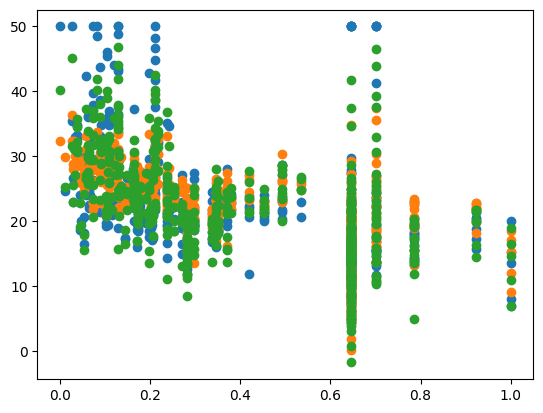

In [17]:

modelGD = LinearRegressionGD(lr=0.01, max_iter=400, tol=1e-3, intercept=True)



start_time = time.time()
stepsGD, errorsGD = modelGD.fit(X_train, y_train)

training_time_GD = time.time() - start_time


modelSGD = LinearRegressionSGD(lr=0.01, max_iter=50, batch_size=4, tol=1e-3, intercept=True)


start_time = time.time()
stepsSGD, errorsSGD = modelSGD.fit(X_train, y_train,reg="L2")
training_time_SGD = time.time() - start_time

MSE_GD_train = modelGD.MSE(X_train, y_train)
MSE_SGD_train = modelSGD.MSE(X_train, y_train)


MSE_GD = modelGD.MSE(X_test, y_test)
MSE_SGD = modelSGD.MSE(X_test, y_test)


print("Сравнение скорости и качества обучения:")
print(f"Время обучения (GD): {training_time_GD} сек.")
print(f"Время обучения (SGD): {training_time_SGD} сек.")
print(f"MSE (GD)test: {MSE_GD}, MSE (GD)train : {MSE_GD_train} ")
print(f"MSE (SGD)test: {MSE_SGD}, MSE (SGD)train: {MSE_SGD_train} ")
# print("Коэффициенты (GD): ", modelGD.theta)
# print("Коэффициенты (SDG): ", modelSGD.theta)

y_pred_GD = modelGD.predict(X)
y_pred_SGD = modelSGD.predict(X)
X_numpy = X.to_numpy()  # Преобразовать DataFrame в NumPy массив
plt.scatter(X_numpy[:, 2], y)
plt.scatter(X_numpy[:, 2], y_pred_GD)
plt.scatter(X_numpy[:, 2], y_pred_SGD)

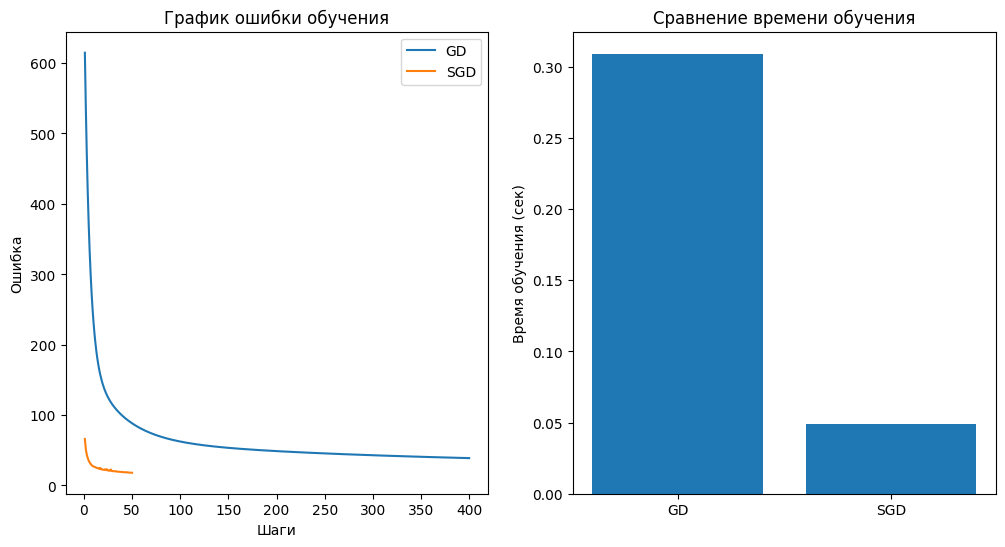

In [6]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(stepsGD, errorsGD, label='GD')
plt.plot(stepsSGD, errorsSGD, label='SGD')
plt.xlabel("Шаги")
plt.ylabel("Ошибка")
plt.legend()
plt.title("График ошибки обучения")

plt.subplot(1, 2, 2)
plt.bar(['GD', 'SGD'], [training_time_GD, training_time_SGD])
plt.ylabel("Время обучения (сек)")
plt.title("Сравнение времени обучения")
plt.show()

3)Подберите в цикле оптимальное, с Вашей точки зрения, значение размера мини-батча и поясните Ваш выбор.

In [7]:
start_time = time.time()
modelSGD = LinearRegressionSGD(lr=0.01, max_iter=400, batch_size=4, tol=1e-3, intercept = True)
steps, errors = modelSGD.fit(X, y)
print("Время обучения:", time.time() - start_time)
# Predict using predict method from model
Y_pred = modelSGD.predict(X)
print("MSE: ", np.mean((Y_pred - y) ** 2))
print("Коэффициенты: ", modelSGD.theta)

Время обучения: 0.3431210517883301
MSE:  11.01030172370774
Коэффициенты:  [ 1.08384216e+01 -1.74888231e+00 -1.79470308e+00  1.22760790e+00
  1.36760828e+00  4.23224188e+00  1.23123828e+01  4.42412399e+00
 -5.54187979e+00  7.16583298e+00  1.63964712e+00  3.20556210e+00
  8.05968812e+00 -1.37034007e+00  3.58620110e-01  1.05141179e+00
 -1.03491717e-01  2.28002894e+00 -2.41278151e+00 -1.72006169e+00
 -1.79226121e+00 -6.65242143e-01 -2.50862986e+00 -1.48699885e+00
 -7.04971715e-01 -2.55463672e+00 -1.44680544e+00  2.25180643e+00
 -3.26404014e+00  1.55041574e+00  1.85617201e-01  6.78146189e+00
 -3.35618857e+00 -1.20036112e+00 -1.60268128e-01  1.39042489e+00
  1.65940590e-01 -1.93376718e+00  5.04745360e-01  2.97787121e+00
  2.67830486e+00  7.29786646e-01 -4.85118805e+00  3.20344889e+00
 -4.35651171e+00  1.51794739e+00  3.02395967e+00 -4.43982056e+00
  5.99081754e-01 -4.23978061e+00  8.28639373e-01 -7.70265075e+00
 -4.77091175e+00  1.92379428e+00 -9.04525154e-01  3.73806477e+00
  4.82427719e+00

Batch Size: 1, Training Time: 0.920602560043335 s, MSE: 11.499272341659356
Batch Size: 2, Training Time: 0.4829990863800049 s, MSE: 11.258238690732286
Batch Size: 4, Training Time: 0.27700209617614746 s, MSE: 11.840868732476187
Batch Size: 8, Training Time: 0.16681218147277832 s, MSE: 13.224795640833102
Batch Size: 16, Training Time: 0.11799860000610352 s, MSE: 16.985164027036085
Batch Size: 32, Training Time: 0.09099936485290527 s, MSE: 20.111965110346517
Batch Size: 64, Training Time: 0.0820000171661377 s, MSE: 23.412739510604144


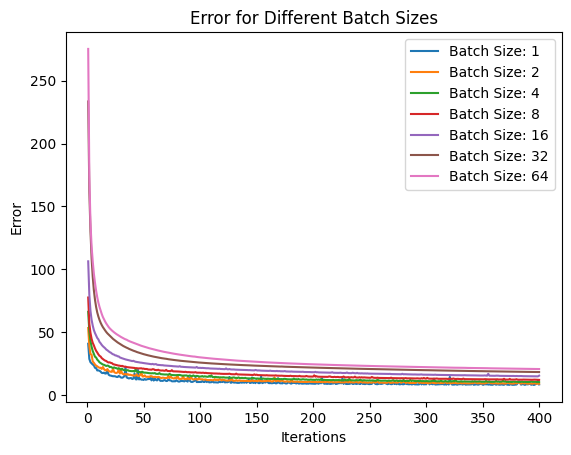

In [29]:
import matplotlib.pyplot as plt

batch_sizes = [1, 2, 4, 8, 16, 32, 64]
results = []

for batch_size in batch_sizes:
    model_sgd = LinearRegressionSGD(lr=0.01, max_iter=400, batch_size=batch_size, tol=1e-3, intercept=True)
    start_time = time.time()
    steps, errors = model_sgd.fit(X_train, y_train)
    training_time = time.time() - start_time
    mse = model_sgd.MSE(X_test, y_test)
    results.append((batch_size, training_time, mse))
    plt.plot(steps, errors, label=f'Batch Size: {batch_size}')

for batch_size, training_time, mse in results:
    print(f"Batch Size: {batch_size}, Training Time: {training_time} s, MSE: {mse}")

plt.xlabel('Iterations')
plt.ylabel('Error')
plt.legend()
plt.title('Error for Different Batch Sizes')
plt.show()



--------------------------------------

При переборе различных batch_size при разных max_iter,мы нашли закономерность: при растущем времени на обучение алгоритма и росте точности, точность при размере батча в 4 единицы растёт непропорционально мало, а значит при учете времени обучения и точности размер батча в 4 единицы при данном наборе данных считаю наиболее оптимальным.

-------------------------------------------

4)Реализуйте в классе LinearRegressionSGD стохастический градиентный спуск с регуляризацией L1, L2, ElasticNet и подберите оптимальные параметры регуляризации, чтобы сократить разрыв качества на обучающей и тестовой выборке.

For L1 regularization, optimal lambda: 0.000379269019073225,rho:None, Min difference: 0.65
MSE train: 13.85, MSE test: 14.50
For L2 regularization, optimal lambda: 6.158482110660267e-05,rho:None, Min difference: 0.62
MSE train: 13.86, MSE test: 14.48
For ElasticNet regularization, optimal lambda: 0.000379269019073225,rho:0.7, Min difference: 0.72
MSE train: 14.04, MSE test: 14.76


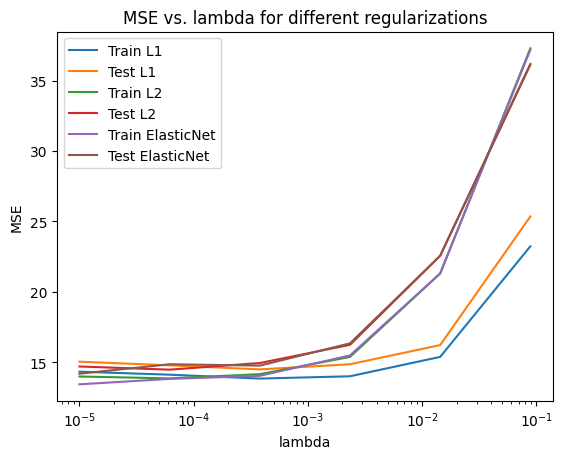

In [15]:

reg_regr = LinearRegressionSGD()
regs = ["L1", "L2", "ElasticNet"]
lambdas = np.logspace(-5, 10, 20)
rhos=np.linspace(0.1,0.7,2)

lambda_differences = {}
best_results = {reg: {'lambda': None, 'rho':None, 'min_difference': float('inf'), 'MSE_train': None, 'MSE_test': None} for reg in regs}
train_scores_all = {reg: [] for reg in regs}
test_scores_all = {reg: [] for reg in regs}

for reg in regs:
    for l in lambdas:
        x_i = X_train.copy()
        x_i.insert(0, "intercept", np.ones((x_i.shape[0], 1)), allow_duplicates=True)
        x_i_test = X_test.copy()
        x_i_test.insert(0, "intercept", np.ones((x_i_test.shape[0], 1)), allow_duplicates=True)
        if reg=="ElasticNet":
            for rho in rhos:
                steps, errors = reg_regr.fit(x_i, y_train, intercept=True, alpha=0.01, epsylon=0.00001, max_steps=1000, reg=reg, lam=l, rho=rho)


        steps, errors = reg_regr.fit(x_i, y_train, intercept=True, alpha=0.01, epsylon=0.00001, max_steps=1000, reg=reg, lam=l)
        
        mse_train = reg_regr.MSE(x_i, y_train)
        mse_test = reg_regr.MSE(x_i_test, y_test)
        difference = abs(mse_train - mse_test)

        if mse_train < 40 and mse_test < 40:
            train_scores_all[reg].append(mse_train)
            test_scores_all[reg].append(mse_test)

        if difference < best_results[reg]['min_difference'] and mse_train < 40 and mse_test < 40:
            best_results[reg]['min_difference'] = difference
            best_results[reg]['lambda'] = l
            best_results[reg]['MSE_train'] = mse_train
            best_results[reg]['MSE_test'] = mse_test
            if reg=='ElasticNet':
                best_results[reg]['rho'] = rho


for reg, train_scores in train_scores_all.items():
    test_scores = test_scores_all[reg]
    if train_scores and test_scores and len(train_scores) == len(test_scores):
        plt.semilogx(lambdas[:len(train_scores)], train_scores, label=f"Train {reg}")
        plt.semilogx(lambdas[:len(test_scores)], test_scores, label=f"Test {reg}")

for reg, results in best_results.items():
    print(f"For {reg} regularization, optimal lambda: {results['lambda']},rho:{results['rho']}, Min difference: {results['min_difference']:.2f}")
    print(f"MSE train: {results['MSE_train']:.2f}, MSE test: {results['MSE_test']:.2f}")

plt.legend()
plt.xlabel('lambda')
plt.ylabel('MSE')
plt.title('MSE vs. lambda for different regularizations')
plt.show()